In [2]:
# Load required libraries
library(randomForest)
library(tidyverse)

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::combine()  masks randomForest::combine()
✖ dplyr::filter()   masks stats::filter()
✖ dplyr::lag()      masks stats::lag()
✖ ggplot2::margin() masks randomForest::margin()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [3]:
# Load the training and test data
train_data <- read.csv("/kaggle/input/wine-quality-prediction/train.csv")
test_data <- read.csv("/kaggle/input/wine-quality-prediction/test.csv")
train_data <- train_data %>%
    mutate(type_white = as.numeric(type == "white"),
         type_red = as.numeric(type == "red"))%>%
  select(-type)
test_data <- test_data %>%
    mutate(type_white = as.numeric(type == "white"),
         type_red = as.numeric(type == "red"))%>%
  select(-type)
summary(test_data)
head(train_data)


       id       fixed.acidity   volatile.acidity  citric.acid    
 Min.   :  13   Min.   : 4.80   Min.   :0.0800   Min.   :0.0000  
 1st Qu.:1603   1st Qu.: 6.50   1st Qu.:0.2300   1st Qu.:0.2400  
 Median :3160   Median : 7.00   Median :0.3000   Median :0.3250  
 Mean   :3204   Mean   : 7.26   Mean   :0.3525   Mean   :0.3212  
 3rd Qu.:4822   3rd Qu.: 7.70   3rd Qu.:0.4200   3rd Qu.:0.4000  
 Max.   :6497   Max.   :13.00   Max.   :1.5800   Max.   :0.7800  
 residual.sugar     chlorides       free.sulfur.dioxide total.sulfur.dioxide
 Min.   : 0.700   Min.   :0.01500   Min.   :  3.00      Min.   :  7.00      
 1st Qu.: 1.800   1st Qu.:0.04000   1st Qu.: 16.00      1st Qu.: 64.75      
 Median : 2.500   Median :0.04800   Median : 29.00      Median :116.00      
 Mean   : 4.992   Mean   :0.05741   Mean   : 30.46      Mean   :111.77      
 3rd Qu.: 7.400   3rd Qu.:0.06600   3rd Qu.: 41.00      3rd Qu.:156.00      
 Max.   :23.500   Max.   :0.41300   Max.   :146.50      Max.   :366.50      

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,type_white,type_red
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
1,6.6,0.3,0.36,1.2,0.035,43,126,0.9909,3.01,0.63,11.4,6,1,0
2,7.7,0.5,0.26,1.9,0.062,9,31,0.9966,3.39,0.64,9.6,5,0,1
3,8.4,0.5,0.35,2.9,0.076,21,127,0.9976,3.23,0.63,9.2,5,0,1
4,7.5,0.4,0.33,5.0,0.045,30,131,0.9942,3.32,0.44,10.9,6,1,0
5,6.4,0.2,0.25,20.2,0.083,35,157,0.9998,3.17,0.50,9.1,5,1,0
6,7.6,0.3,0.52,13.2,0.042,61,148,0.9984,2.98,0.47,9.1,6,1,0


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

corrplot 0.92 loaded



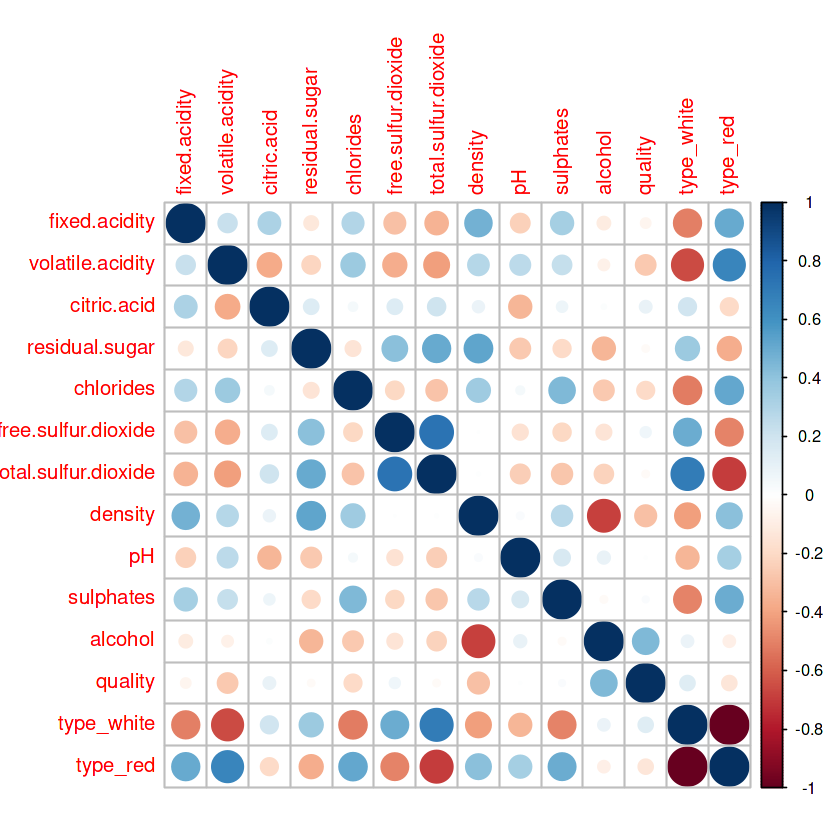

In [4]:
install.packages("corrplot")
library(corrplot)
train_data.cor <- cor(train_data)

corrplot(train_data.cor)

In [1]:
summary(train_data)

ERROR: Error in summary(train_data): object 'train_data' not found


In [20]:
# Split the training data into X (features) and y (target)
X_train <- train_data%>%
  select(-quality)  # Exclude the 'quality' column
y_train <- train_data$quality


In [21]:
# Train the Random Forest Regression model
model <- randomForest(y_train ~ ., data = X_train)

# Predict quality for test data
X_test <- test_data %>% select(-id)
predicted_quality <- predict(model, X_test)

In [22]:
# Create 'result.csv'
result_df <- data.frame(id = test_data$id, quality = predicted_quality)

# Save 'result.csv'
write.csv(result_df, "result.csv", row.names = FALSE)

In [29]:
n_folds <- 5
mtry_values <- c(2, 4, 6, 8)

# Tạo list để lưu kết quả cross-validation
cv_results <- list()

# Thực hiện cross-validation cho từng giá trị mtry
for (mtry in mtry_values) {
  set.seed(123)  # Đảm bảo kết quả tái sử dụng
  folds <- createFolds(y_train, k = n_folds)  # Chia dữ liệu thành các folds

  rmse_values <- c()  # Tạo một vector để lưu kết quả RMSE từ mỗi fold

  for (i in 1:n_folds) {
    train_indices <- unlist(folds[-i])  # Chỉ mục của tập huấn luyện trong fold i
    test_indices <- unlist(folds[i])  # Chỉ mục của tập kiểm tra trong fold i

    X_train_fold <- X_train[train_indices, ]
    y_train_fold <- y_train[train_indices]
    X_test_fold <- X_train[test_indices, ]
    y_test_fold <- y_train[test_indices]

    rf_model <- randomForest(y_train_fold ~ ., data = X_train_fold, ntree = 1000)
    predictions <- predict(rf_model, newdata = X_test_fold)

    rmse <- sqrt(mean((y_test_fold - predictions)^2))
    rmse_values <- c(rmse_values, rmse)
  }

  # Lưu kết quả RMSE từ tất cả các folds vào cv_results
  cv_results[[as.character(mtry)]] <- rmse_values
}

# Hiển thị kết quả cross-validation
print(cv_results)